Relevant Information:

   This is a very difficult regression task. It can be used to test regression methods. Also,
   it could be used to test outlier detection methods, since it is not clear how many outliers
   are there. Yet, the number of examples of fires with a large burned area is very small.

5. Number of Instances: 517 

6. Number of Attributes: 12 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
   feature selection.

7. Attribute information:

   For more information, read [Cortez and Morais, 2007].

   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform). 

8. Missing Attribute Values: None


Objective: The objective of the jupyter notebook is to build good model to predict how much area would be burn during fire.
The data can be used for both classification and regression task. Several data scientist converted the target variable which is 
continous in nature into binary categorial variable to perform the classification task in order to predict whether there would be burnt or not. However, our approach have been first to visualize the data and later perform regression task.


### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics 
from scipy import stats

from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, ElasticNetCV 
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
import scikit_posthocs as sp

In [3]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, KFold

In [4]:
data = pd.read_csv("forestfires.csv") # load data
data.head() # displacy data 

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [5]:
data.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

Data contains month and day as categorical variable, we need to find whether month or day impacts the target variable
or not. The other like X, Y, DMC, DC, RH, temp etc are numeric

In [6]:
data.shape # only 517 rows are there in data with 13 overall features

(517, 13)

In [7]:
data.describe() # five point summary

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Above value shows that mean and median of most of the variables are not which indicates that the data is not normally
distributed, it might be due to outliers

The interesting facts is that rain max value 6.4,median and min value of rain is zero, which is little bit strange.
To get explaination we need to converse with the dedicated data provider team. Since, the data is downloaded from kaggle and we do not have that solution to connect with data team, we would like to go ahead for the analysis. 


In [8]:
data.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [9]:
data.duplicated().sum() # duplicated data is there

4

In [10]:
data.isnull().sum() # no null values are there in the data 

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [11]:
try :  # dropping the duplicated values
    data.drop_duplicates(inplace=True)
except:
    pass

In [12]:
data.select_dtypes(exclude =object).corr() # correlation matrix 

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.542705,-0.020499,-0.048861,-0.088801,0.006033,-0.051070,0.083757,0.020869,0.065176,0.062930
Y,0.542705,1.000000,-0.045979,0.008210,-0.098496,-0.023142,-0.023871,0.062587,-0.019537,0.033313,0.045168
FFMC,-0.020499,-0.045979,1.000000,0.383641,0.332936,0.532083,0.431609,-0.300827,-0.029208,0.056806,0.040232
DMC,-0.048861,0.008210,0.383641,1.000000,0.681741,0.304585,0.469590,0.071711,-0.105111,0.074780,0.073783
DC,-0.088801,-0.098496,0.332936,0.681741,1.000000,0.228168,0.497584,-0.044067,-0.203010,0.035690,0.050313
ISI,0.006033,-0.023142,0.532083,0.304585,0.228168,1.000000,0.394217,-0.133363,0.106825,0.067664,0.008411
temp,-0.051070,-0.023871,0.431609,0.469590,0.497584,0.394217,1.000000,-0.528670,-0.227618,0.069526,0.098222
RH,0.083757,0.062587,-0.300827,0.071711,-0.044067,-0.133363,-0.528670,1.000000,0.071433,0.099616,-0.075460
wind,0.020869,-0.019537,-0.029208,-0.105111,-0.203010,0.106825,-0.227618,0.071433,1.000000,0.061479,0.012699
rain,0.065176,0.033313,0.056806,0.074780,0.035690,0.067664,0.069526,0.099616,0.061479,1.000000,-0.007418


The corrleation matrix shows there negligible or week correlation with each variable

The correlation of target variable (aread) is very almost negligible with independent variable. Which is not good for 
building predictive model. Now, need to check if these problem can be addressed via data transformation technique

Pair plots


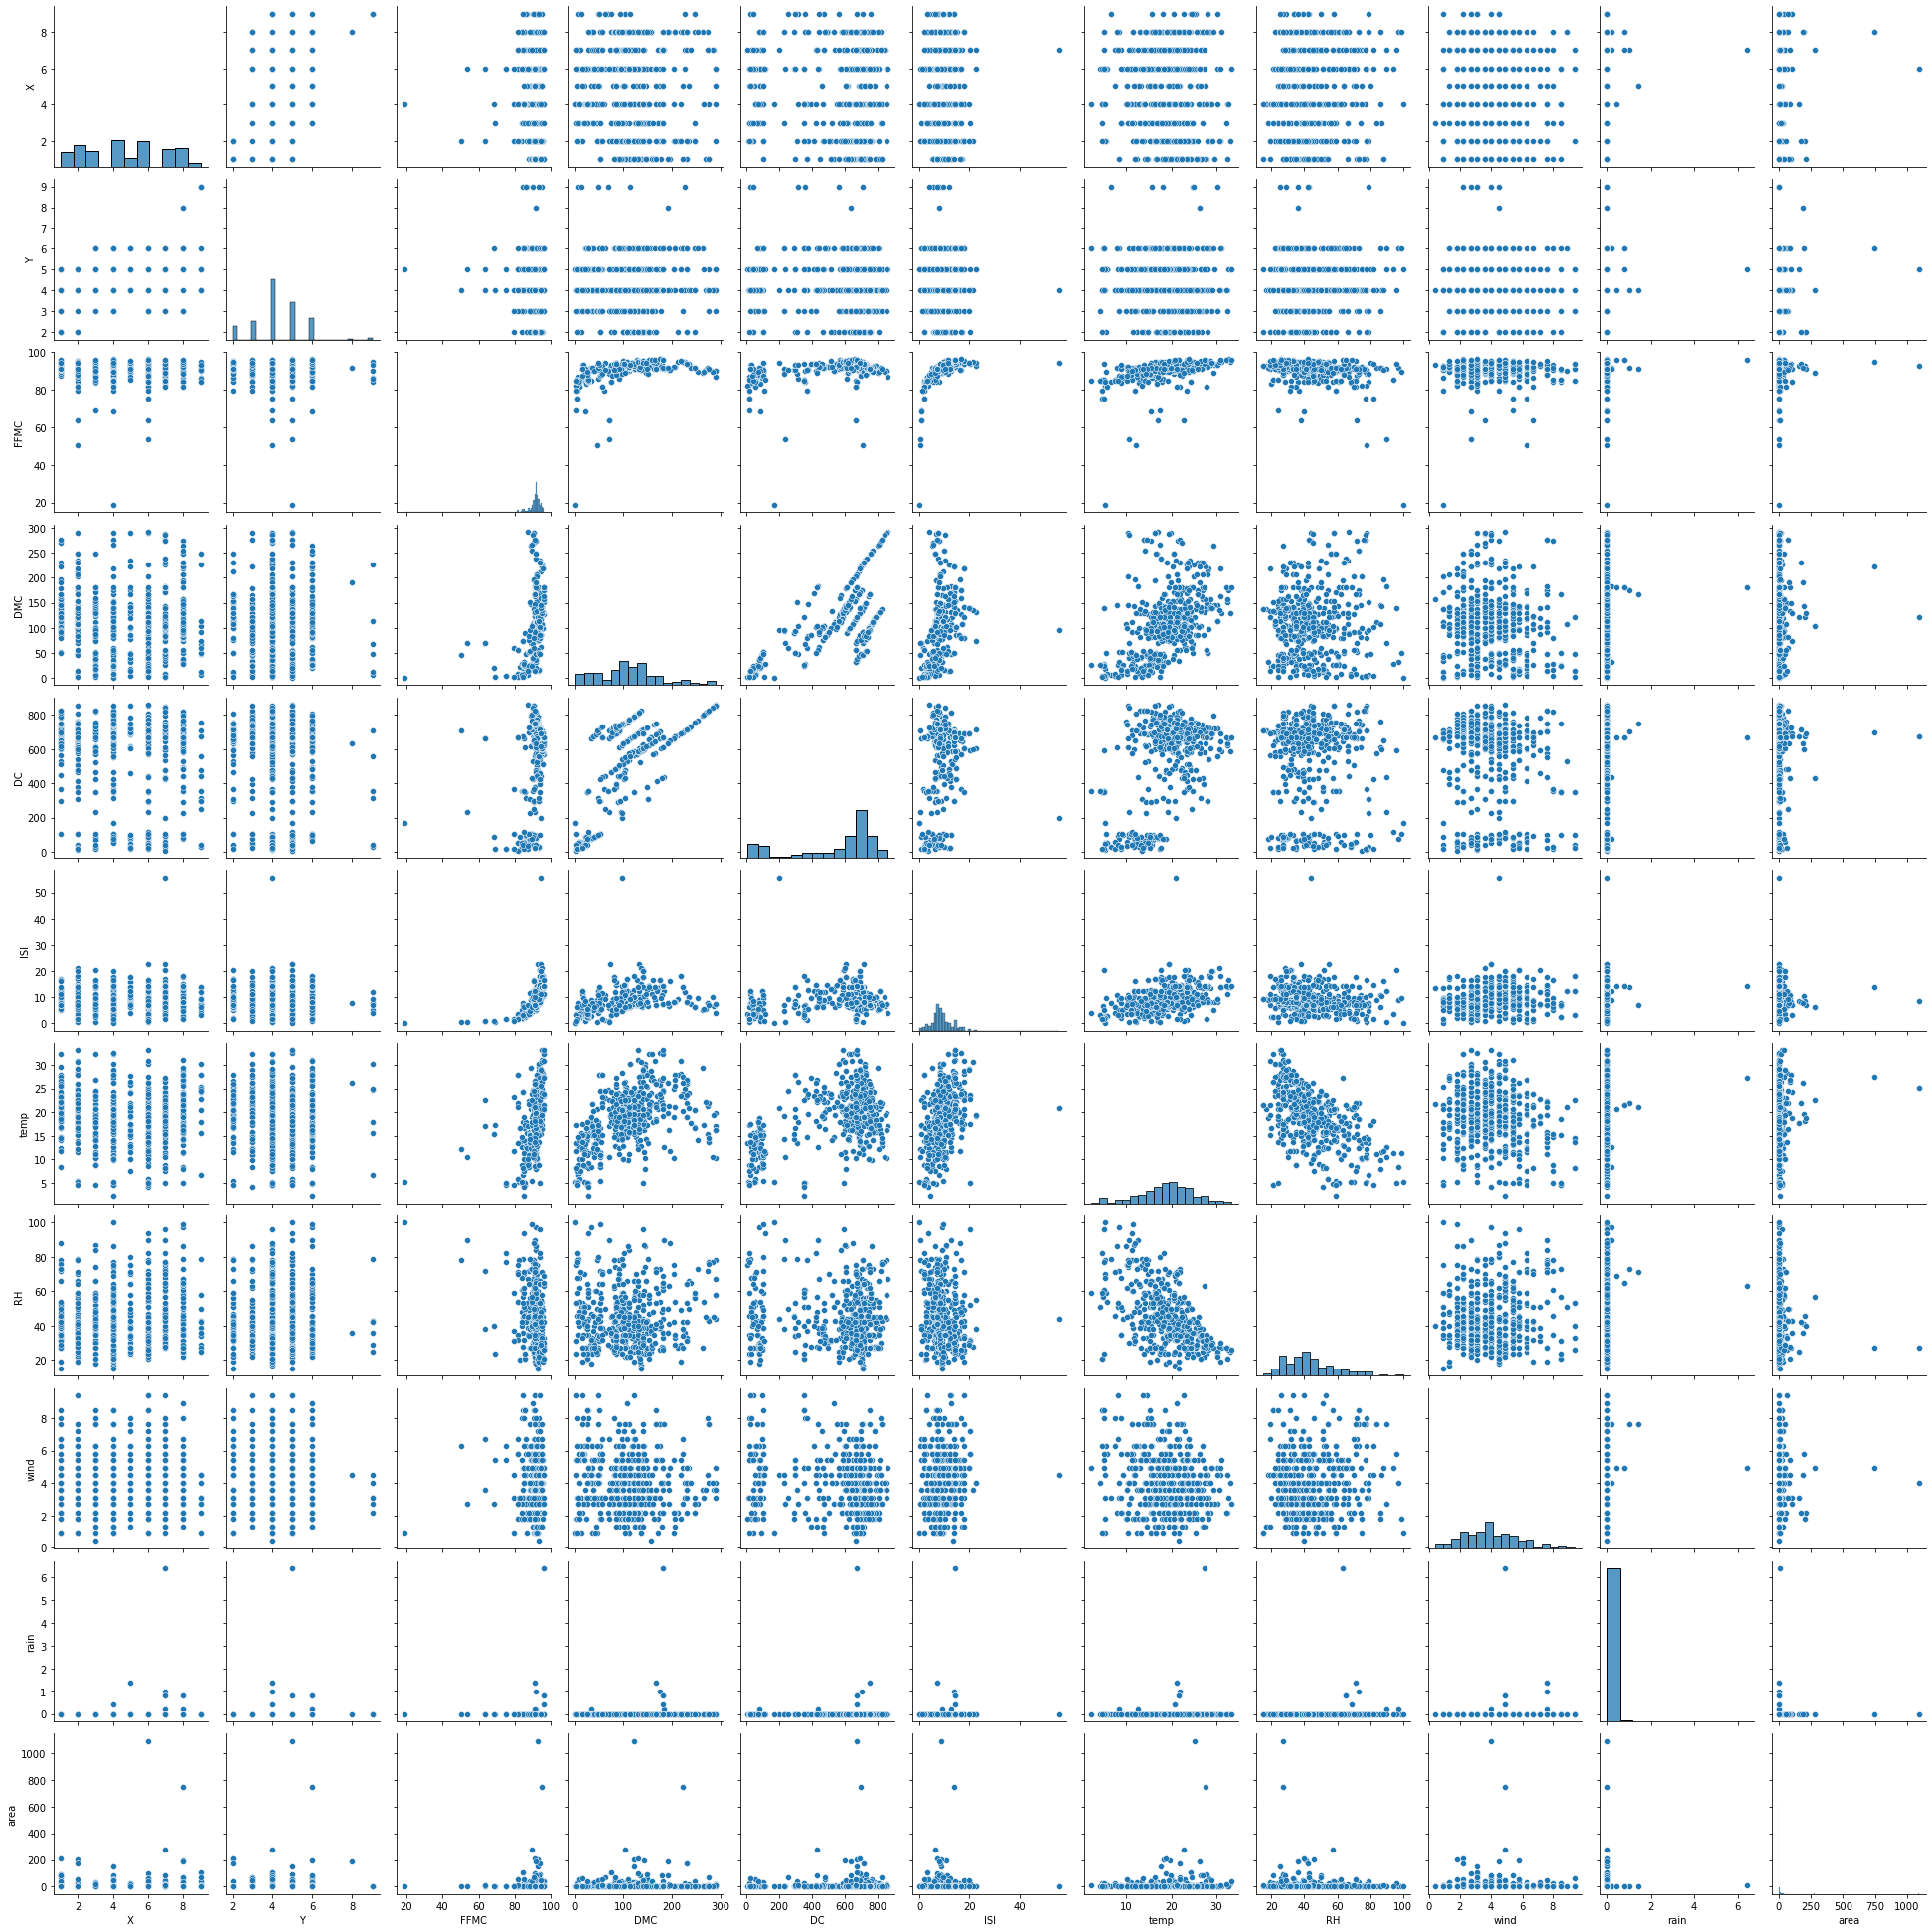

In [13]:
sns.pairplot(data.select_dtypes(exclude =object))
print("Pair plots")
plt.show()

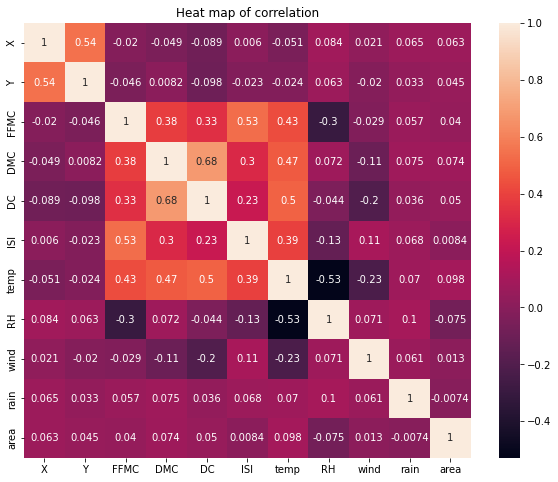

In [14]:
plt.figure(figsize = (10,8))
plt.title("Heat map of correlation")
sns.heatmap(data.select_dtypes(exclude =object).corr(),annot=True)
plt.show()

There is a week correlation among independent variable

The correlation between aread and independent variable should be high unfortunately this is not the case with our
heat map matrix

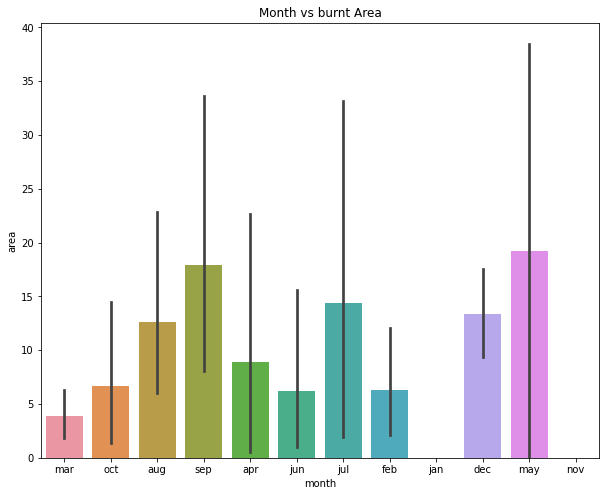

In [15]:
plt.figure(figsize = (10,8))
plt.title('Month vs burnt Area')
sns.barplot(x = data['month'],y=data['area'])
plt.show()

The value for burnt area in jan and nov is very less and very high in the month of may and sep

The difference in the burn area is varying a lot , there is a high chance that month will play a major role in the burning 
of forest. Later, we will explore this further with hypothesis

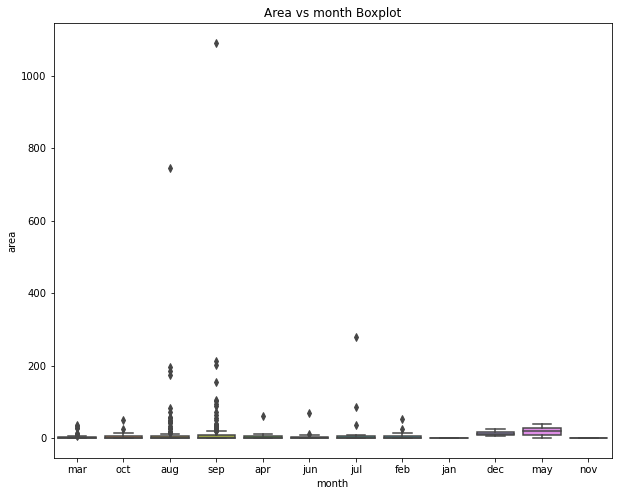

In [16]:
plt.figure(figsize = (10,8))
plt.title("Area vs month Boxplot")
sns.boxplot(x = data['month'],y=data['area'])
plt.show()

Box plot depicts that there are lots of month which contains outliers, these represents the true picture which states the 
intensity of burn

In [17]:
data[data['area']==0]['area'].count() # these shows that almost 50% of the data present in the data set contains zero burnt
# the data contains only few 50% of the value which shows value of area other than zero
# the values for prediction is very less 

244

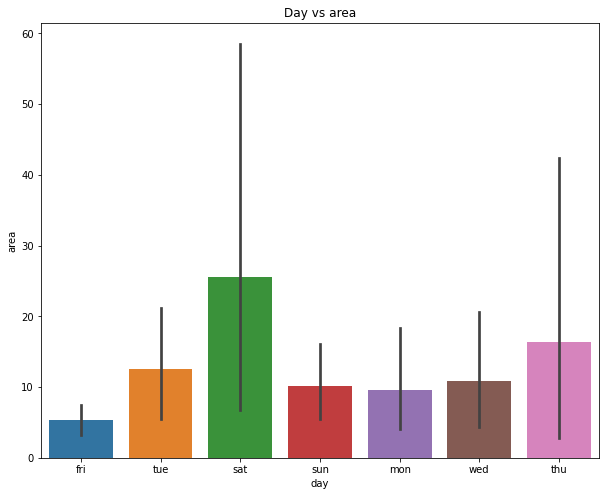

In [18]:
plt.figure(figsize = (10,8))
plt.title("Day vs area")
sns.barplot(x = data['day'],y=data['area'])
plt.show()

Mean area  for the saturday and varies significantly than other means. Hypothesis test further will let us know which comination
are effecting the target variable

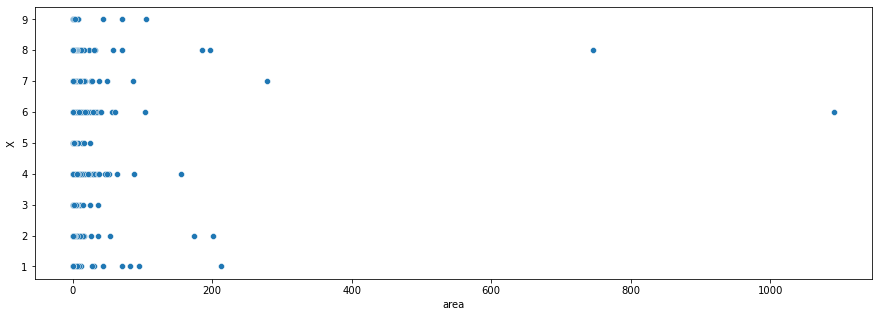

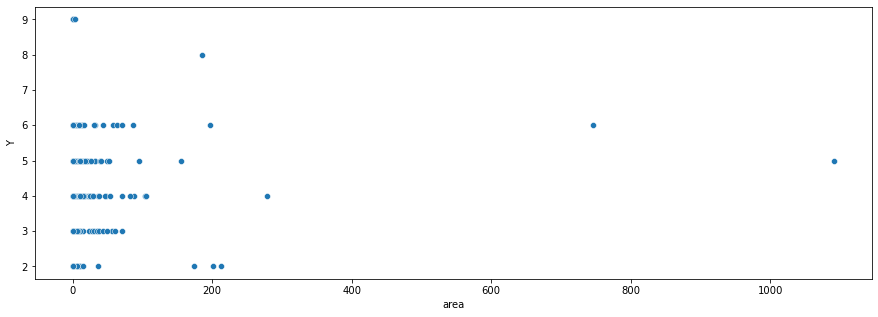

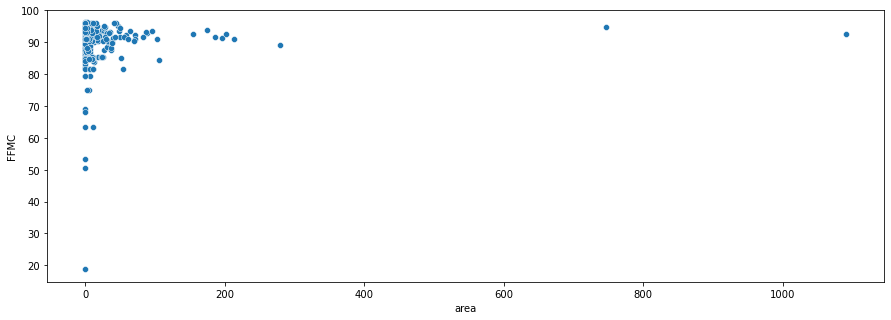

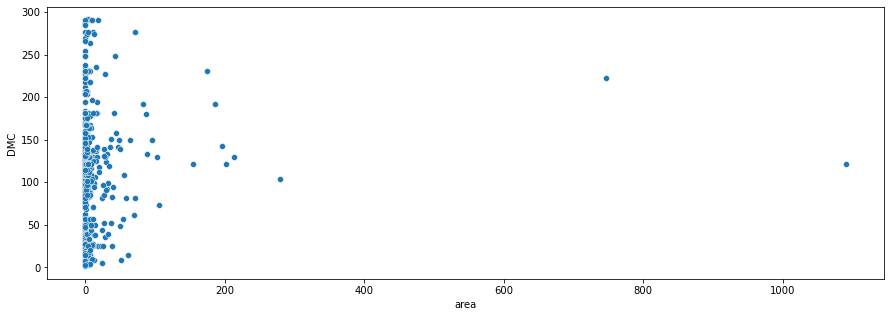

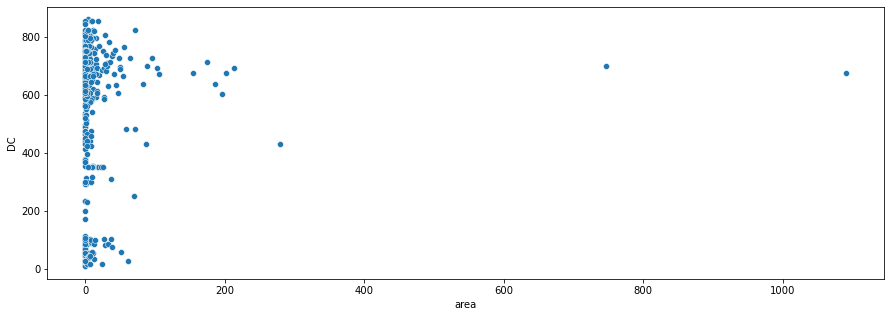

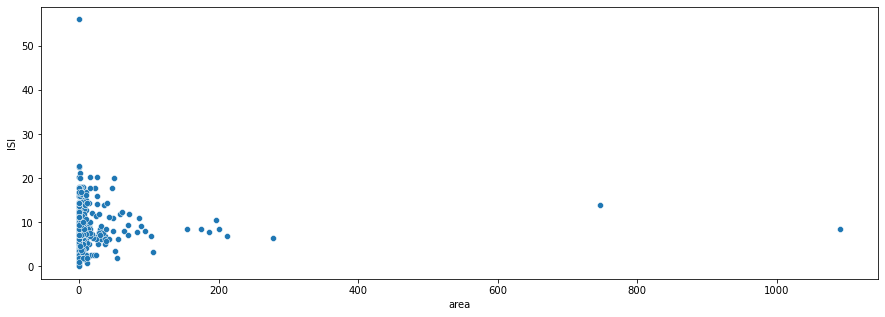

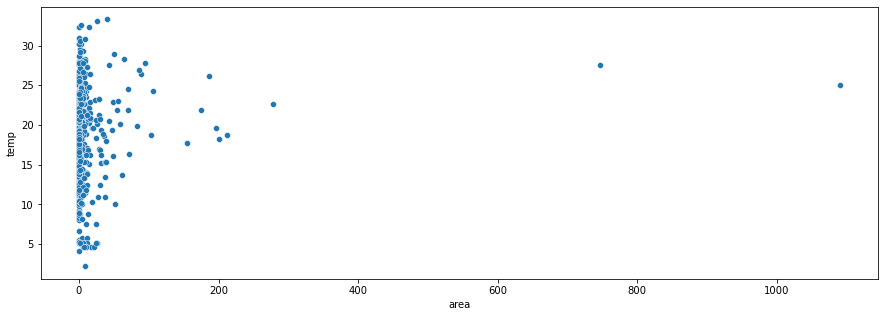

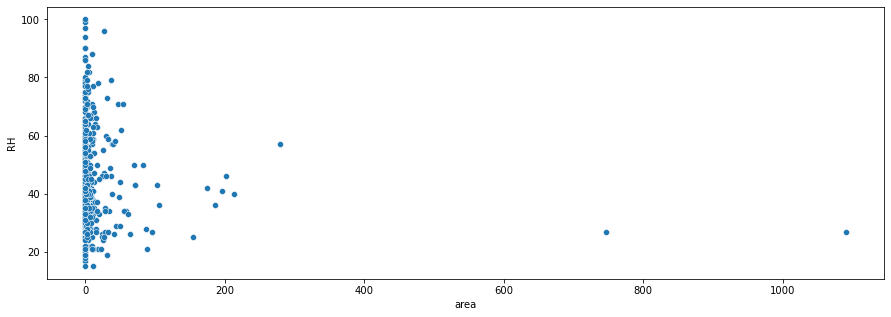

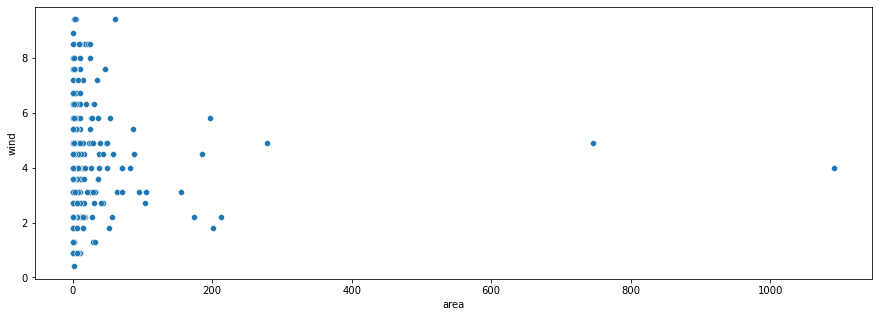

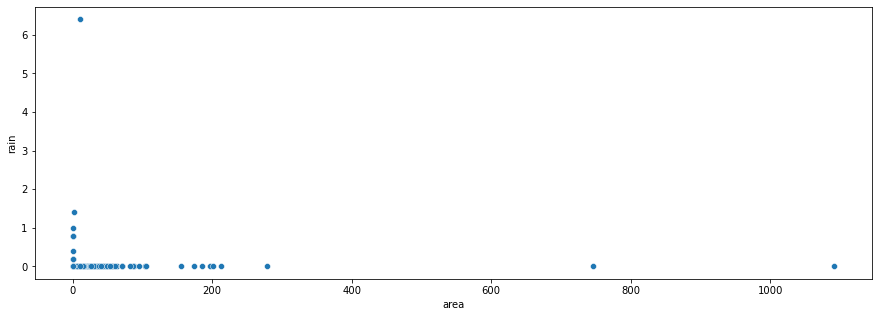

In [19]:
for col in data.select_dtypes(exclude=object):
    if col!='area':
        plt.figure(figsize =(15,5))
        sns.scatterplot(x = data['area'], y = data[col])
        plt.show()

From the corrleation matrix and above scatter plot it is clear there is no strong relationship between response and independent variable

# Finding significant features

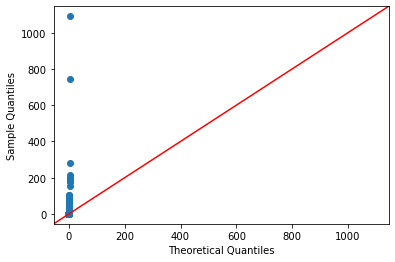

In [20]:
sm.qqplot(data['area'], line='45')
plt.show() # qq plot shows that area does not follow normal distribution

In [21]:
# Normality test
# HO(Null Hypothesis): area follows normal distribution
#H1(Alternate Hypothesis): Area does not follow normal distribution 
print(stats.shapiro(data['area']))
print(stats.jarque_bera(data['area']))
# nomality test fails as the p value is very less than 0.05, rejecting null hypothesis
# it concludes that area does not follow normal distribution

ShapiroResult(statistic=0.1708219051361084, pvalue=1.8132802128363133e-42)
Jarque_beraResult(statistic=792479.0408080862, pvalue=0.0)


In [24]:
# Since area does not follow normal distribution we cannot apply ANNOVA test to check the significance months and days
# We need to use non parametric test Kruskal to find the significance of the test
#Ho(null hypothesis) : median values of all groups are same, or month is not significant 
#H!(alternate hypothesis): median values of at leas one median groups are not same 

list_month = []
month_list = [month for  month in data['month'].unique()]
for i, month in enumerate(month_list):
    a = list(data[data['month']==month]['area'])
    list_month.append(a)

stats.kruskal(list_month[0],
             list_month[1],
             list_month[2],
             list_month[3],
             list_month[4],
             list_month[5],
             list_month[6],
              list_month[7],
             list_month[8],
             list_month[9],
             list_month[10],
             list_month[11])

# here p value is less than 0.05, reject null hypothesis, it means at least one pair of month group effects the area
# to find that pair need to do the posthoc analysis

KruskalResult(statistic=24.468111630901355, pvalue=0.010897730079719585)

In [26]:
# data transformation for dunn test (post hoc analysis of kruskal walis test)
# dunn hypothesis
dunn = [data[data['month']=='jan']['area'],
        data[data['month']=='feb']['area'],
        data[data['month']=='mar']['area'],
        data[data['month']=='apr']['area'],
        data[data['month']=='may']['area'],
        data[data['month']=='jun']['area'],
        data[data['month']=='jul']['area'],
        data[data['month']=='aug']['area'],
        data[data['month']=='sep']['area'],
        data[data['month']=='oct']['area'],
        data[data['month']=='nov']['area'],
        data[data['month']=='dec']['area'] 
       ]
## further post hoc analysis

#test is that there is no difference between the median values of the two groups being compared. 
#The alternative hypothesis is that there is a difference between the median values of the two groups being compared.
# Dunn's test hypothesis
# Ho (null hypothesis) : no difference between the median values of the two months being compared
# H1 (alternate hypothesis) : there is a difference between the median values of the two groups being compared
#The test statistic for the Dunn's test is the
p_values= sp.posthoc_dunn(dunn, p_adjust = 'bonferroni')
p_values

,1,2,3,4,5,6,7,8,9,10,11,12
1,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.00000,1.0,0.363169
2,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.00000,1.0,0.158753
3,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,0.484298,1.00000,1.0,0.001480
4,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.00000,1.0,0.457853
5,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.00000,1.0,1.000000
6,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.00000,1.0,0.089910
7,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.00000,1.0,0.084295
8,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.00000,1.0,0.021771
9,1.000000,1.000000,0.484298,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.00000,1.0,0.079495
10,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.00000,1.0,0.041860


From above p value it is clear that p value of dec and march , dec and aug, dec and oct effects the area 


In [27]:
list_day = []
for day in data['day'].unique():
    a = list(data[data['day']==day]['area'])
    list_day.append(a)

stats.kruskal(list_day[0],
             list_day[1],
             list_day[2],
             list_day[3],
             list_day[4],
             list_day[5],
             list_day[6])
# p values for the days featues is more than 0.05, fail to reject null, so we conclude that days do not effects
#significantly to the target variable (area)

KruskalResult(statistic=1.1665493718675084, pvalue=0.9785046949231585)

In [28]:
# checking significance of numerical and target features

for col in data.drop('area',axis =1).select_dtypes(exclude = object):
    print(col,stats.shapiro(data[col]))
    
# no attribute is normal, going for non parametri test

X ShapiroResult(statistic=0.9370056986808777, pvalue=6.585706237077424e-14)
Y ShapiroResult(statistic=0.904597818851471, pvalue=2.1702494540453697e-17)
FFMC ShapiroResult(statistic=0.5326918959617615, pvalue=1.1129601176572054e-34)
DMC ShapiroResult(statistic=0.9639652967453003, pvalue=6.79813483284164e-10)
DC ShapiroResult(statistic=0.8001592755317688, pvalue=1.183106074126404e-24)
ISI ShapiroResult(statistic=0.8648169636726379, pvalue=1.2086622554544192e-20)
temp ShapiroResult(statistic=0.9870321154594421, pvalue=0.00015873339725658298)
RH ShapiroResult(statistic=0.946393609046936, pvalue=1.1410614206980307e-12)
wind ShapiroResult(statistic=0.9665170907974243, pvalue=2.0093025021594713e-09)
rain ShapiroResult(statistic=0.04675781726837158, pvalue=1.6815581571897805e-44)


In [29]:
# checking significance of numerical and target features
# spearman hypothesis for two tail test
# Ho (Null hypothesis): correlation =0, there is no significant correlation 
#H1(Alternate hypothesis): correlation !=0 , thre is significant corrleation 

for col in data.drop('area',axis =1).select_dtypes(exclude = object):
    print(col,stats.spearmanr(data['area'],data[col]))
# nothing is normal, going for non parametri test

X SpearmanrResult(correlation=0.05833656671979231, pvalue=0.18710400549711076)
Y SpearmanrResult(correlation=0.047182444519377385, pvalue=0.28613163699351396)
FFMC SpearmanrResult(correlation=0.024650825771203717, pvalue=0.5774921508851003)
DMC SpearmanrResult(correlation=0.07684322635581628, pvalue=0.08207224590677518)
DC SpearmanrResult(correlation=0.06279568732317593, pvalue=0.15554261041138723)
ISI SpearmanrResult(correlation=0.014618072877943838, pvalue=0.7411717224469054)
temp SpearmanrResult(correlation=0.08119742888524373, pvalue=0.06611688113246766)
RH SpearmanrResult(correlation=-0.021774209120252363, pvalue=0.622697912578131)
wind SpearmanrResult(correlation=0.056021636187168385, pvalue=0.20524041244236885)
rain SpearmanrResult(correlation=-0.06466191878515773, pvalue=0.1435991527419204)


In [30]:
stats.shapiro(np.log(data['area']+1)) #applying transformation

ShapiroResult(statistic=0.7992249131202698, pvalue=1.0540920145972599e-24)

In [31]:
# checking significance of numerical and target features
# spearman hypothesis for two tail test
# Ho (Null hypothesis): correlation =0, there is no significant correlation 
#H1(Alternate hypothesis): correlation !=0 , thre is significant corrleation 

for col in data.drop('area',axis =1).select_dtypes(exclude = object):
    print(col,stats.spearmanr(data['area'],np.log(data['area']+1)))
# we conclude that p value of all attribute is very less than .05,reject null hypothesis, hence all features are 
# significant

X SpearmanrResult(correlation=0.9999999999999998, pvalue=0.0)
Y SpearmanrResult(correlation=0.9999999999999998, pvalue=0.0)
FFMC SpearmanrResult(correlation=0.9999999999999998, pvalue=0.0)
DMC SpearmanrResult(correlation=0.9999999999999998, pvalue=0.0)
DC SpearmanrResult(correlation=0.9999999999999998, pvalue=0.0)
ISI SpearmanrResult(correlation=0.9999999999999998, pvalue=0.0)
temp SpearmanrResult(correlation=0.9999999999999998, pvalue=0.0)
RH SpearmanrResult(correlation=0.9999999999999998, pvalue=0.0)
wind SpearmanrResult(correlation=0.9999999999999998, pvalue=0.0)
rain SpearmanrResult(correlation=0.9999999999999998, pvalue=0.0)


# Model building

In [32]:
# segregating categorival and numerical column names 
cat_columns_list = list(data.select_dtypes(include = object).columns)
num_columns_list = list(data.drop('area',axis =1).select_dtypes(exclude = object).columns)

# vectorization (one hot encoding) for the text variables
oneHOtTransformer = OneHotEncoder(drop='first',sparse=False)
X_cat = oneHOtTransformer.fit_transform(data[cat_columns_list])
df_cat = pd.DataFrame(X_cat, columns= oneHOtTransformer.get_feature_names_out())

#apply scaler to numerical features 
scaler =MinMaxScaler()
X_scaled = scaler.fit_transform(data[num_columns_list])
df_scaled_num = pd.DataFrame(X_scaled, columns= scaler.get_feature_names_out())

# combining both the numerical and categorical feature
df_combine = pd.concat( [df_scaled_num,df_cat],axis =1)

# adding constant which is necessary steps for the OLS method of fitting the model
df_combine = sm.add_constant(df_combine) 
df_combine.head() # transformed data 

,const,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,...,month_may,month_nov,month_oct,month_sep,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,1.0,0.750,0.428571,0.870968,0.086492,0.101325,0.090909,0.192926,0.423529,0.700000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.750,0.285714,0.927742,0.118194,0.775419,0.119430,0.508039,0.211765,0.055556,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.750,0.285714,0.927742,0.146795,0.796294,0.119430,0.398714,0.211765,0.100000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.875,0.571429,0.941935,0.110958,0.081623,0.160428,0.196141,0.964706,0.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.875,0.571429,0.910968,0.172984,0.110590,0.171123,0.295820,0.988235,0.155556,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
df_combine.columns
df_combine['area'] = data['area'] # adding target variable  to data
print(df_combine.shape)
df_combine = df_combine.sample(frac=1,random_state=10) # shuffling the data 
print(df_combine.shape)

(513, 29)
(513, 29)


In [34]:
X = df_combine.drop('area',axis=1)
y= data['area']

X_train, X_test, y_train, y_test = train_test_split(  X, y, test_size=0.2, random_state=42)
print('train X',X_train.shape) ;print('train y',y_train.shape)
print('test X',X_test.shape)
print('test y',y_test.shape)

train X (410, 28)
train y (410,)
test X (103, 28)
test y (103,)


In [35]:
y = np.array(y) # fitting logistic regression model with OLS method
mod = sm.OLS(y, X)
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.6765
Date:                Wed, 26 Apr 2023   Prob (F-statistic):              0.891
Time:                        09:56:03   Log-Likelihood:                -2850.6
No. Observations:                 513   AIC:                             5757.
Df Residuals:                     485   BIC:                             5876.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1948     61.233      0.330      0.742    -100.120     140.510
X             17.0168     12.154      1.400      0.162      -6.865      40.898
Y             -9.8922     20.023     -0.494      0.622     -49.235      29.451
FFMC           2.0517     60.254      0.034      0.973    -116.340     120.443
DMC           39.7847     25.461      1.563      0.119     -10.242      89.811
DC           -42.0613     50.641     -0.831      0.407    -141.563      57.441
ISI          -12.7949     47.212     -0.271      0.786    -105.560      79.971
temp         -10.5294     32.435     -0.325      0.746     -74.259      53.200
RH           -11.9882     24.819     -0.483      0.629     -60.755      36.779
wind           5.1175     16.162      0.317      0.752     -26.639      36.874
rain         -50.4481     64.105     -0.787      0.432    -176.407      75.510
month_aug      1.4279     38.515      0.037      0.970     -74.248      77.104
month_dec      0.5445     37.288      0.015      0.988     -72.721      73.810
month_feb    -17.4508     26.181     -0.667      0.505     -68.894      33.992
month_jan    -10.1652     56.919     -0.179      0.858    -122.004     101.673
month_jul    -12.6798     33.400     -0.380      0.704     -78.307      52.947
month_jun    -14.9193     31.049     -0.481      0.631     -75.927      46.089
month_mar    -17.9358     23.652     -0.758      0.449     -64.409      28.537
month_may    -17.4282     51.377     -0.339      0.735    -118.377      83.520
month_nov    -52.3116     68.988     -0.758      0.449    -187.864      83.240
month_oct     11.0845     45.903      0.241      0.809     -79.108     101.277
month_sep     12.1778     43.135      0.282      0.778     -72.577      96.933
day_mon        0.5097     10.617      0.048      0.962     -20.351      21.370
day_sat        1.5090     10.219      0.148      0.883     -18.570      21.588
day_sun        9.1191      9.941      0.917      0.359     -10.413      28.651
day_thu        2.3740     11.252      0.211      0.833     -19.734      24.482
day_tue       32.6544     11.005      2.967      0.003      11.032      54.277
day_wed        5.3201     11.612      0.458      0.647     -17.497      28.137
==============================================================================
Omnibus:                      950.206   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           692452.869
Skew:                          12.106   Prob(JB):                         0.00
Kurtosis:                     181.351   Cond. No.                         69.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

THe OLS method shows above is not good, p value of ANNOVA test of the model is very high which is greater than 0.05 and 
says that model is nog significant or worth to consider.

Let's improve the model

In [36]:
X.columns

Index(['const', 'X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue',
       'day_wed'],
      dtype='object')

In [37]:
# improving OLS logisitic regression model 
mod = sm.OLS(y, X[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain','month_oct','month_dec','month_aug','month_mar']])
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.046
Model:                            OLS   Adj. R-squared (uncentered):              0.020
Method:                 Least Squares   F-statistic:                              1.736
Date:                Wed, 26 Apr 2023   Prob (F-statistic):                      0.0456
Time:                        09:56:03   Log-Likelihood:                         -2858.1
No. Observations:                 513   AIC:                                      5744.
Df Residuals:                     499   BIC:                                      5804.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             14.2540     11.935      1.194      0.233      -9.195      37.703
Y             -8.6836     19.695     -0.441      0.659     -47.379      30.012
FFMC          12.3574     23.914      0.517      0.606     -34.626      59.341
DMC           21.2847     21.314      0.999      0.318     -20.592      63.162
DC             0.2822     17.912      0.016      0.987     -34.910      35.475
ISI           -8.0443     41.528     -0.194      0.846     -89.636      73.547
temp         -14.8889     27.090     -0.550      0.583     -68.114      38.336
RH           -12.1676     19.708     -0.617      0.537     -50.888      26.553
wind           8.9727     15.624      0.574      0.566     -21.724      39.669
rain         -24.0014     62.589     -0.383      0.702    -146.972      98.969
month_oct     -0.3285     18.438     -0.018      0.986     -36.555      35.898
month_dec     -0.1163     26.210     -0.004      0.996     -51.612      51.379
month_aug     -0.7258      7.341     -0.099      0.921     -15.150      13.698
month_mar     -3.2497     13.529     -0.240      0.810     -29.830      23.330
==============================================================================
Omnibus:                      972.878   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           786273.534
Skew:                          12.706   Prob(JB):                         0.00
Kurtosis:                     193.102   Cond. No.                         35.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now the p value of ANNOVA model is less than 0.05, it means model is good to go , the difference between adjusted r2square
value and r2 value is very much , it means there are more ingsignificant variables in the model. We need to improve the
model further by removing the variable with p value and evaluating it again

In [38]:
# improving OLS logisitic regression model 
mod = sm.OLS(y, X[['X', 'Y', 'FFMC', 'DMC', 'ISI', 'temp', 'RH', 'wind',
       'rain','month_aug','month_mar']]) # month_dec', DC, month_oct
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.046
Model:                            OLS   Adj. R-squared (uncentered):              0.026
Method:                 Least Squares   F-statistic:                              2.223
Date:                Wed, 26 Apr 2023   Prob (F-statistic):                      0.0124
Time:                        09:56:04   Log-Likelihood:                         -2858.1
No. Observations:                 513   AIC:                                      5738.
Df Residuals:                     502   BIC:                                      5785.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             14.2315     11.796      1.206      0.228      -8.944      37.407
Y             -8.7144     19.271     -0.452      0.651     -46.577      29.148
FFMC          12.3891     20.824      0.595      0.552     -28.523      53.301
DMC           21.5187     17.265      1.246      0.213     -12.402      55.439
ISI           -8.0348     40.882     -0.197      0.844     -88.355      72.285
temp         -14.7587     24.304     -0.607      0.544     -62.508      32.991
RH           -12.1093     18.392     -0.658      0.511     -48.244      24.026
wind           8.9544     14.913      0.600      0.548     -20.345      38.254
rain         -24.0393     62.308     -0.386      0.700    -146.455      98.376
month_aug     -0.7461      7.183     -0.104      0.917     -14.859      13.367
month_mar     -3.3161     10.889     -0.305      0.761     -24.709      18.077
==============================================================================
Omnibus:                      972.916   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           786469.328
Skew:                          12.707   Prob(JB):                         0.00
Kurtosis:                     193.126   Cond. No.                         32.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Applying the transformation in OLS model

In [39]:
# improving OLS logisitic regression model 
y_train_transformed = np.log(y_train+1)
y_transformed = np.log(y+1)
mod = sm.OLS(y_transformed, X[[  'FFMC', 'ISI','wind','temp'
       ]]) # month_dec', DC, month_oct,DMC, month_mar", RH,X,'Y',month_aug,'rain','temp','wind'
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.397
Model:                            OLS   Adj. R-squared (uncentered):              0.392
Method:                 Least Squares   F-statistic:                              83.60
Date:                Wed, 26 Apr 2023   Prob (F-statistic):                    1.55e-54
Time:                        09:56:04   Log-Likelihood:                         -895.82
No. Observations:                 513   AIC:                                      1800.
Df Residuals:                     509   BIC:                                      1817.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC           0.9490      0.296      3.203      0.001       0.367       1.531
ISI           -2.2505      0.857     -2.625      0.009      -3.935      -0.566
wind           0.7031      0.318      2.209      0.028       0.078       1.328
temp           0.5745      0.387      1.483      0.139      -0.187       1.336
==============================================================================
Omnibus:                       93.634   Durbin-Watson:                   0.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.744
Skew:                           1.197   Prob(JB):                     6.12e-32
Kurtosis:                       3.999   Cond. No.                         16.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model is good as F-stat value is high, AIC score is less 

The durbin watson number is less than 2 which says there is presence of auto correlation which is

Jarque-Bera test conveys that target variable does not follow normald distribution

The value of FFMC  coef means that if there is unit change in FFMC the change is  area v would be 0.949

The value of ISI negatively impacts the burnt area, if there is unit change i ISI index the area would be -2.2505 hectare

temp effects the least to the burnt area, however ISI index is very dominating

The model can explain the 39% variance in the burn area easily using four paramter namely : FFMC index, ISI index, 

wind and temperature

In [42]:
significant_col = [  'FFMC', 'ISI','wind','temp']
mod = sm.OLS(y_transformed, X[[  'FFMC', 'ISI','wind','temp'
       ]]) 
result = mod.fit()
y_train_transformed = np.log(y_train+1)
print( 'test mean absolute error',metrics.mean_squared_error(y_test, np.exp(result.predict(X_test[significant_col]))-1))
print('train mean absolute error', metrics.mean_squared_error(y_train, np.exp(result.predict(X_train[significant_col]))-1))

test mean absolute error 411.2613986918359
train mean absolute error 5140.38407442633


In [43]:
vif_data = pd.DataFrame()
Xvif = X
vif_data["feature"] = Xvif.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(Xvif.values, i)
                          for i in range(len(Xvif.columns))]

In [44]:
vif_data.sort_values(by ='VIF', ascending=False)

,feature,VIF
0,const,463.145079
21,month_sep,51.221744
11,month_aug,41.943315
5,DC,26.683337
15,month_jul,8.059498
20,month_oct,7.387684
17,month_mar,6.401401
7,temp,4.554647
4,DMC,3.910075
16,month_jun,3.598275


In [45]:
### Checking other models 

In [46]:
#list of models
list_models = [('linear',LinearRegression()),
              ("Lasso",Lasso()),
              ('Ridge',Ridge()),
              ('Elastic net',ElasticNet()),
              ('Gradient',GradientBoostingRegressor()),
              ('Ada',AdaBoostRegressor()),
               ("Random",RandomForestRegressor()),
              ('SVR',SVR()),
              ('KNN', KNeighborsRegressor())]

In [47]:
list_models[0][0]

'linear'

In [48]:
def TestingModels(ModelList, X_train, y_train, X_test, y_test, Transformation = True):
    
    for model  in ModelList:
        if Transformation: # transformation true 
            y_train_transformed = np.log(y_train+1) # apply transformation 

            try:
                rfe = RFE(model[1]) # apply rfe
                rfe= rfe.fit(X_train,y_train_transformed)

                selected_col = list(rfe.get_feature_names_out())

                modelApply = model[1]
                modelApply.fit(X_train[selected_col], y_train_transformed)
                print(f'\n{model[0]}')
                print( 'test mean absolute error',metrics.mean_squared_error(y_test, np.exp(modelApply.predict(X_test[selected_col]))-1))
                print('train mean absolute error', metrics.mean_squared_error(y_train, np.exp(modelApply.predict(X_train[selected_col]))-1))
            
            except:
                modelApply = model[1] #
                modelApply.fit(X_train, y_train_transformed)
                print(f'\n{model[0]}')
                print( 'test mean absolute error',metrics.mean_squared_error(y_test, np.exp(modelApply.predict(X_test))-1))
                print('train mean absolute error', metrics.mean_squared_error(y_train, np.exp(modelApply.predict(X_train))-1))
        
        
        else: # no transformation
            try:
                rfe = RFE(model[1]) # apply rfe
                rfe= rfe.fit(X_train,y_train)

                selected_col = list(rfe.get_feature_names_out())

                modelApply = model[1]
                modelApply.fit(X_train[selected_col], y_train)
                print(f'\n{model[0]}')
                print( 'test mean absolute error',metrics.mean_squared_error(y_test, modelApply.predict(X_test[selected_col])))
                print('train mean absolute error', metrics.mean_squared_error(y_train, modelApply.predict(X_train[selected_col])))
            
            except:
                modelApply = model[1] #
                modelApply.fit(X_train, y_train)
                print(f'\n{model[0]}')
                print( 'test mean absolute error',metrics.mean_squared_error(y_test, modelApply(X_test)))
                print('train mean absolute error', metrics.mean_squared_error(y_train, modelApply(X_train)))

            
        

In [49]:
TestingModels(list_models,X_train, y_train, X_test, y_test)


linear
test mean absolute error 411.2831304921349
train mean absolute error 5130.211902388642

Lasso
test mean absolute error 411.1934064655276
train mean absolute error 5139.274229249031

Ridge
test mean absolute error 406.17332602876814
train mean absolute error 5131.705222000454

Elastic net
test mean absolute error 411.1934064655276
train mean absolute error 5139.274229249031

Gradient
test mean absolute error 399.56732594443844
train mean absolute error 4747.248158672739

Ada
test mean absolute error 404.3884413250518
train mean absolute error 4631.57947117496

Random
test mean absolute error 405.5926350013551
train mean absolute error 3720.7730821412533

SVR
test mean absolute error 411.53941698714016
train mean absolute error 5164.618731319794

KNN
test mean absolute error 406.95506386665386
train mean absolute error 5063.713635871761


In [50]:
TestingModels(list_models,X_train[significant_col], y_train, X_test[significant_col], y_test) # applying model with significant variables


linear
test mean absolute error 409.5578255660431
train mean absolute error 5138.288836128289

Lasso
test mean absolute error 411.1934064655276
train mean absolute error 5139.274229249031

Ridge
test mean absolute error 409.52057795517146
train mean absolute error 5138.286298366664

Elastic net
test mean absolute error 411.1934064655276
train mean absolute error 5139.274229249031

Gradient
test mean absolute error 406.2291429307407
train mean absolute error 4881.33708740319

Ada
test mean absolute error 403.6393548022964
train mean absolute error 4999.483890976758

Random
test mean absolute error 473.0703898304553
train mean absolute error 3813.6624168207004

SVR
test mean absolute error 423.42051519377884
train mean absolute error 5169.667784295413

KNN
test mean absolute error 403.03411444467844
train mean absolute error 5063.030952366973


In [51]:
# From above we can see that Gradient boost regressor is doing well , there is less gap in train and test ans shows better fit
#of the algorithm

In [52]:
modelApply = GradientBoostingRegressor()
y_train_transformed = np.log(y_train+1)
modelApply.fit(X_train, y_train_transformed)
print( 'test mean absolute error',metrics.mean_squared_error(y_test, np.exp(modelApply.predict(X_test))-1))
print('train mean absolute error', metrics.mean_squared_error(y_train, np.exp(modelApply.predict(X_train))-1))

test mean absolute error 382.49812864061136
train mean absolute error 4781.455025448821


In [53]:
modelApply = GradientBoostingRegressor()
y_train_transformed = np.log(y_train+1)
modelApply.fit(X_train[significant_col], y_train_transformed)
print( 'test mean absolute error',metrics.mean_squared_error(y_test, np.exp(modelApply.predict(X_test[significant_col]))-1))
print('train mean absolute error', metrics.mean_squared_error(y_train, np.exp(modelApply.predict(X_train[significant_col]))-1))

test mean absolute error 412.38268198754554
train mean absolute error 4783.900244212211


### Tuning Graident Boost Regressor

In [54]:
rfe = RFE(GradientBoostingRegressor()) # apply rfe
rfe= rfe.fit(X_train,y_train_transformed)

selected_col = list(rfe.get_feature_names_out())
print(selected_col)

['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'month_sep', 'day_mon', 'day_sun', 'day_thu', 'day_wed']


In [55]:
estim = GradientBoostingRegressor()
param = {'max_depth':[None, 2,4,6,8,10,12,14,16,18], 'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12,13,14]}
grid = GridSearchCV(estimator= estim, param_grid= param ,cv = 5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid.fit(X_train[selected_col], y_train_transformed)

Fitting 5 folds for each of 130 candidates, totalling 650 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14]},
             scoring='neg_mean_squared_error', verbose=2)

In [56]:
grid.best_params_

{'max_depth': 2, 'min_samples_split': 14}

In [57]:
modelApply = GradientBoostingRegressor(max_depth= 2, min_samples_split=14)
y_train_transformed = np.log(y_train+1)
modelApply.fit(X_train[selected_col], y_train_transformed)
print( 'test mean squared error',metrics.mean_squared_error(y_test, np.exp(modelApply.predict(X_test[selected_col]))-1))
print('train mean squared error', metrics.mean_squared_error(y_train, np.exp(modelApply.predict(X_train[selected_col]))-1))

test mean squared error 401.3538992085346
train mean squared error 5029.492510364483


In [58]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import kernels

In [59]:

kernel = DotProduct() + WhiteKernel()

gpr = GaussianProcessRegressor(kernel=kernel,random_state=10).fit(X_train, y_train_transformed)
print( 'test mean squared error',metrics.mean_squared_error(y_test, np.exp(gpr.predict(X_test))-1))
print('train mean squared error', metrics.mean_squared_error(y_train, np.exp(gpr.predict(X_train))-1))

test mean squared error 404.46959937057835
train mean squared error 5127.859179798957


In [60]:
#! pip install scikit-optimize

In [61]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [62]:
%%time
opt = BayesSearchCV(
...     SVR(),
...     {
...         'C': Real(1e-6, 1e+6, prior='log-uniform'),
...         'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
...         'degree': Integer(1,8),
...         'kernel': Categorical(['linear',  'rbf']),
...     },
...     n_iter=32,
...     random_state=0, scoring ='neg_mean_squared_error', cv=2
... )
>>>
>>> # executes bayesian optimization
>>> opt.fit(X_train, y_train_transformed)
>>>
>>> # model can be saved, used for predictions or scoring
>>> print(opt.score(X_test, y_test))

-423.71124114726894
CPU times: total: 4min 40s
Wall time: 8min 2s


# Conclusion

The purpose of the project was to predict the value of burnt area
Which is impacted by various features like month, ISI index, temperature
Rain etc.

There was some duplicated values in the data set that has been removed
The null values was not present in the data

While performing hypothesis test like spearman to find the significance of
Correlation between numerical independent and response variable it was observed
There was very weak correlation between independent and response feature (area)
.It was improved using log(x+1) transformation

ANOVA test shows that month is significant variables that affects the area while days
Do not. Post hoc analysis accomplished with Dunn’s test conveys that pair of month
Like dec and oct, dec and march, and aug and dec impacts the area significantly.

Severals models were built and evaluated using mean squared error.OLS methods
Depicts that with log(x+1) transformation we can explain the variance of 40% with a simple model. This is the simple model where wald test confirms only four feature were significant
To predict burnt area, the four feature namely are FFM, ISI index , wind and temperature 


Later we tuned the Gradient Boosted Regressor where features were selected using
Recursive feature elimination.  The best performance was obtained with max depth =2
And minimum split = 14

Bayesian regressor was attempted on the model. The performance was good in test data
Not on training data which indicate the presence of high bias in the model. 

Finally we can select OLS best logistic regression model for predictive modelling as it is light
And performing similar to ensemble model.  

All model are showing high biases, this is because the response variables contains almost
50% of the data with zero area, if somehow more  records are taken containing different values other than zero, the model will perform good. 


